<a href="https://colab.research.google.com/github/GeneSUN/Anomaly_Detection_toolkit/blob/main/TimeSeries_Preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -O TimeSeriesFeatureTransformerPandas.py https://raw.githubusercontent.com/GeneSUN/Anomaly_Detection_toolkit/main/Preprocess/TimeSeriesFeatureTransformerPandas.py


--2025-09-23 01:04:16--  https://raw.githubusercontent.com/GeneSUN/Anomaly_Detection_toolkit/main/Preprocess/TimeSeriesFeatureTransformerPandas.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9722 (9.5K) [text/plain]
Saving to: ‘TimeSeriesFeatureTransformerPandas.py’

TimeSeriesFeatureTr 100%[===================>]   9.49K  --.-KB/s    in 0s      

2025-09-23 01:04:16 (62.4 MB/s) - ‘TimeSeriesFeatureTransformerPandas.py’ saved [9722/9722]



In [2]:
import pandas as pd
import numpy as np
from typing import List, Union
import matplotlib.pyplot as plt
from TimeSeriesFeatureTransformerPandas import TimeSeriesFeatureTransformerPandas, split_time_series

TIME_COL = "time"  # default, override when instantiating


# TimeSeries Preprocess

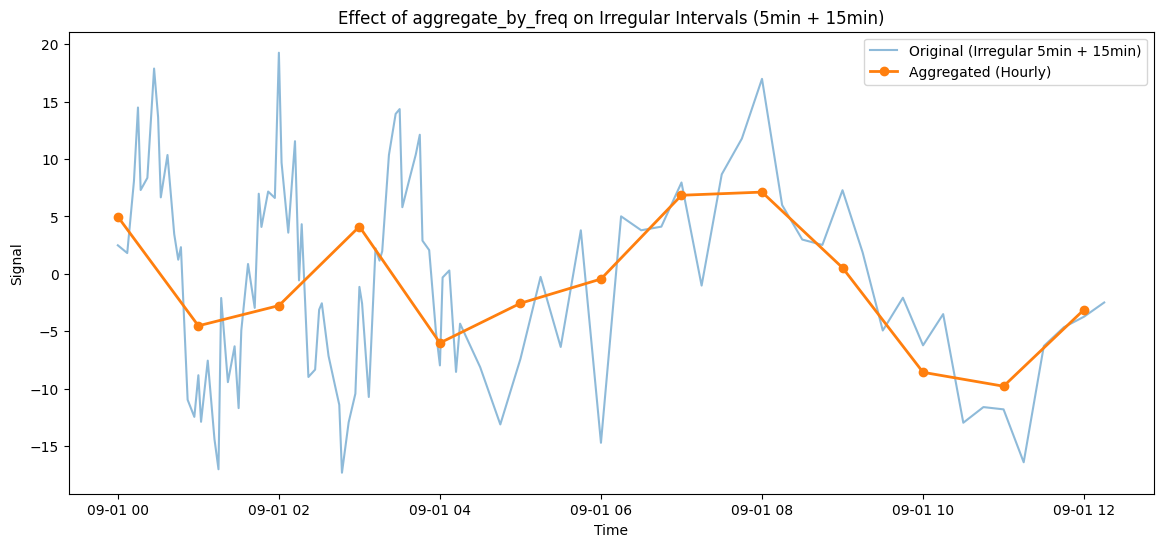

In [3]:
#@title aggregate_by_freq

# --- Synthetic irregular time series ---
np.random.seed(42)

# Generate irregular intervals: alternate 15 min and 5 min
times_15 = pd.date_range("2025-09-01 00:00:00", periods=50, freq="15min")
times_5  = pd.date_range("2025-09-01 00:07:00", periods=50, freq="5min")  # offset to mix with 15 min
times = times_15.union(times_5).sort_values()

# Fluctuating noisy signal
signal = np.sin(np.linspace(0, 25, len(times))) * 10 + np.random.randn(len(times)) * 5

df = pd.DataFrame({
    "sn": ["A"] * len(times),
    "time": times,
    "signal": signal
})

# --- Use Transformer ---
transformer = TimeSeriesFeatureTransformerPandas(df, columns=["signal"], partition_col="sn", time_col="time")

# Original irregular data
df_original = df.copy()

# Aggregate hourly
transformer.aggregate_by_freq(freq="h")
df_hourly = transformer.df_transformed

# --- Plot ---
plt.figure(figsize=(14, 6))
plt.plot(df_original["time"], df_original["signal"], label="Original (Irregular 5min + 15min)", alpha=0.5)
plt.plot(df_hourly["time"], df_hourly["signal"], label="Aggregated (Hourly)", marker="o", linewidth=2)
plt.title("Effect of aggregate_by_freq on Irregular Intervals (5min + 15min)")
plt.xlabel("Time")
plt.ylabel("Signal")
plt.legend()
plt.show()

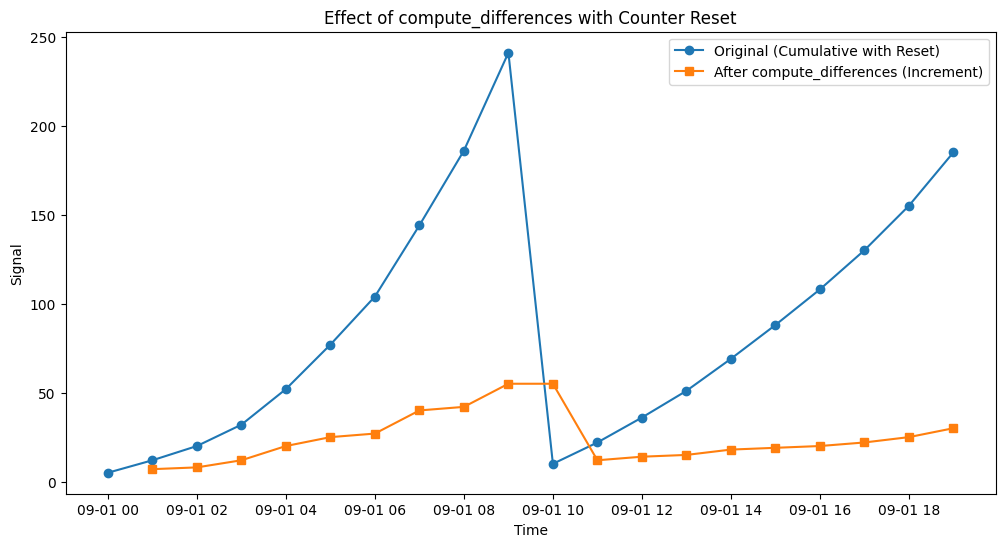

In [4]:
#@title compute_differences
# --- Synthetic cumulative data with reset ---
times = pd.date_range("2025-09-01 00:00:00", periods=20, freq="h")

# Base cumulative growth
cumulative = np.cumsum([5, 7, 8, 12, 20, 25, 27, 40, 42, 55])

# Simulate a counter reset: restart from 10
cumulative_reset = np.cumsum([10, 12, 14, 15, 18, 19, 20, 22, 25, 30])

# Concatenate two parts (with reset)
cumulative_signal = np.concatenate([cumulative, cumulative_reset])

df = pd.DataFrame({
    "sn": ["A"] * len(times),
    "time": times,
    "signal": cumulative_signal
})

# --- Use Transformer ---
transformer = TimeSeriesFeatureTransformerPandas(
    df, columns=["signal"], partition_col="sn", time_col="time"
)
transformer.compute_differences()
df_diff = transformer.df_transformed

# --- Plot ---
plt.figure(figsize=(12, 6))
plt.plot(df["time"], df["signal"], label="Original (Cumulative with Reset)", marker="o")
plt.plot(df_diff["time"], df_diff["signal"], label="After compute_differences (Increment)", marker="s")
plt.title("Effect of compute_differences with Counter Reset")
plt.xlabel("Time")
plt.ylabel("Signal")
plt.legend()
plt.show()


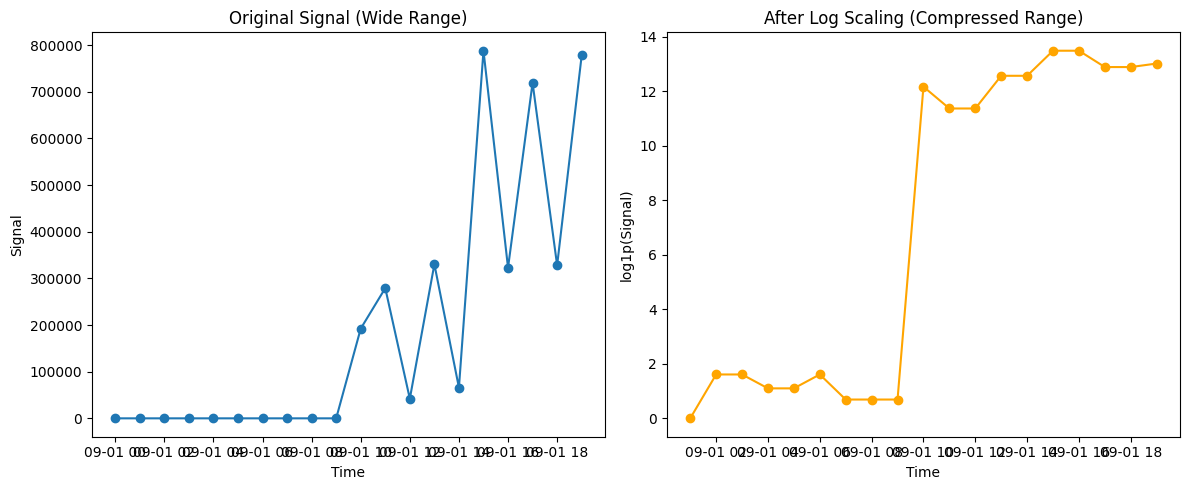

In [5]:

#@title Log Scaling: wide range (small to extremely large) ---
np.random.seed(42)
times = pd.date_range("2025-09-01", periods=20, freq="h")

# Mix small values (1–10) and very large values (1000–1,000,000)
signal = np.concatenate([
    np.random.randint(1, 10, size=10),
    np.random.randint(1000, 1000000, size=10)
])

df = pd.DataFrame({
    "sn": ["A"] * len(times),
    "time": times,
    "signal": signal
})

# --- Use Transformer ---
transformer = TimeSeriesFeatureTransformerPandas(df, columns=["signal"], partition_col="sn", time_col="time")


transformer.apply_log_scaling()
df_log = transformer.df_transformed

# --- Plot Before vs After ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(df["time"], df["signal"], marker="o")
plt.title("Original Signal (Wide Range)")
plt.xlabel("Time")
plt.ylabel("Signal")

plt.subplot(1, 2, 2)
plt.plot(df_log["time"], df_log["signal"], marker="o", color="orange")
plt.title("After Log Scaling (Compressed Range)")
plt.xlabel("Time")
plt.ylabel("log1p(Signal)")

plt.tight_layout()
plt.show()


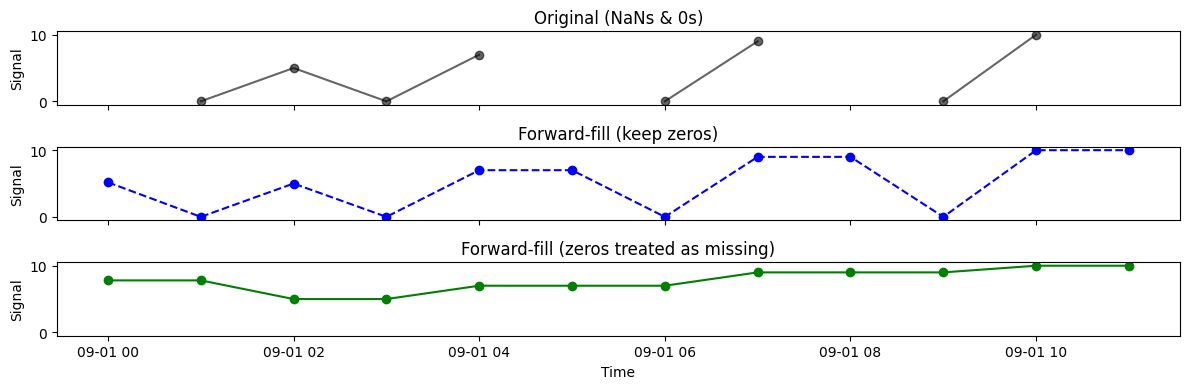

In [6]:
#@title forward_fill NA or Zero

# Create a series with both NaNs and zeros (per partition 'sn')
times = pd.date_range("2025-09-01", periods=12, freq="h")
signal = [np.nan, 0, 5, 0, 7, np.nan, 0, 9, np.nan, 0, 10, np.nan]

df = pd.DataFrame({
    "sn": ["X"] * len(times),
    "time": times,
    "signal": signal
})

# 1) Fill only NaNs, keep zeros
t1 = TimeSeriesFeatureTransformerPandas(df, columns=["signal"], partition_col="sn", time_col="time")
t1.aggregate_by_freq("h")
t1.forward_fill(treat_zero_as_missing=False, fallback="group_mean")
df_keep_zero = t1.df_transformed

# 2) Treat zeros as missing (fill both zeros & NaNs)
t2 = TimeSeriesFeatureTransformerPandas(df, columns=["signal"], partition_col="sn", time_col="time")
t2.aggregate_by_freq("h")
t2.forward_fill(treat_zero_as_missing=True, fallback="group_mean")
df_fill_zero = t2.df_transformed

# Plot comparison
fig, axes = plt.subplots(3, 1, figsize=(12, 4), sharex=True, sharey=True)

# Original
axes[0].plot(df["time"], df["signal"], marker="o", color="black", alpha=0.6)
axes[0].set_title("Original (NaNs & 0s)")
axes[0].set_ylabel("Signal")

# Forward-fill (keep zeros)
axes[1].plot(df_keep_zero["time"], df_keep_zero["signal"], marker="o", color="blue", linestyle="--")
axes[1].set_title("Forward-fill (keep zeros)")
axes[1].set_ylabel("Signal")

# Forward-fill (zeros treated as missing)
axes[2].plot(df_fill_zero["time"], df_fill_zero["signal"], marker="o", color="green")
axes[2].set_title("Forward-fill (zeros treated as missing)")
axes[2].set_xlabel("Time")
axes[2].set_ylabel("Signal")

plt.tight_layout()
plt.show()



# Split long_series to sub-series

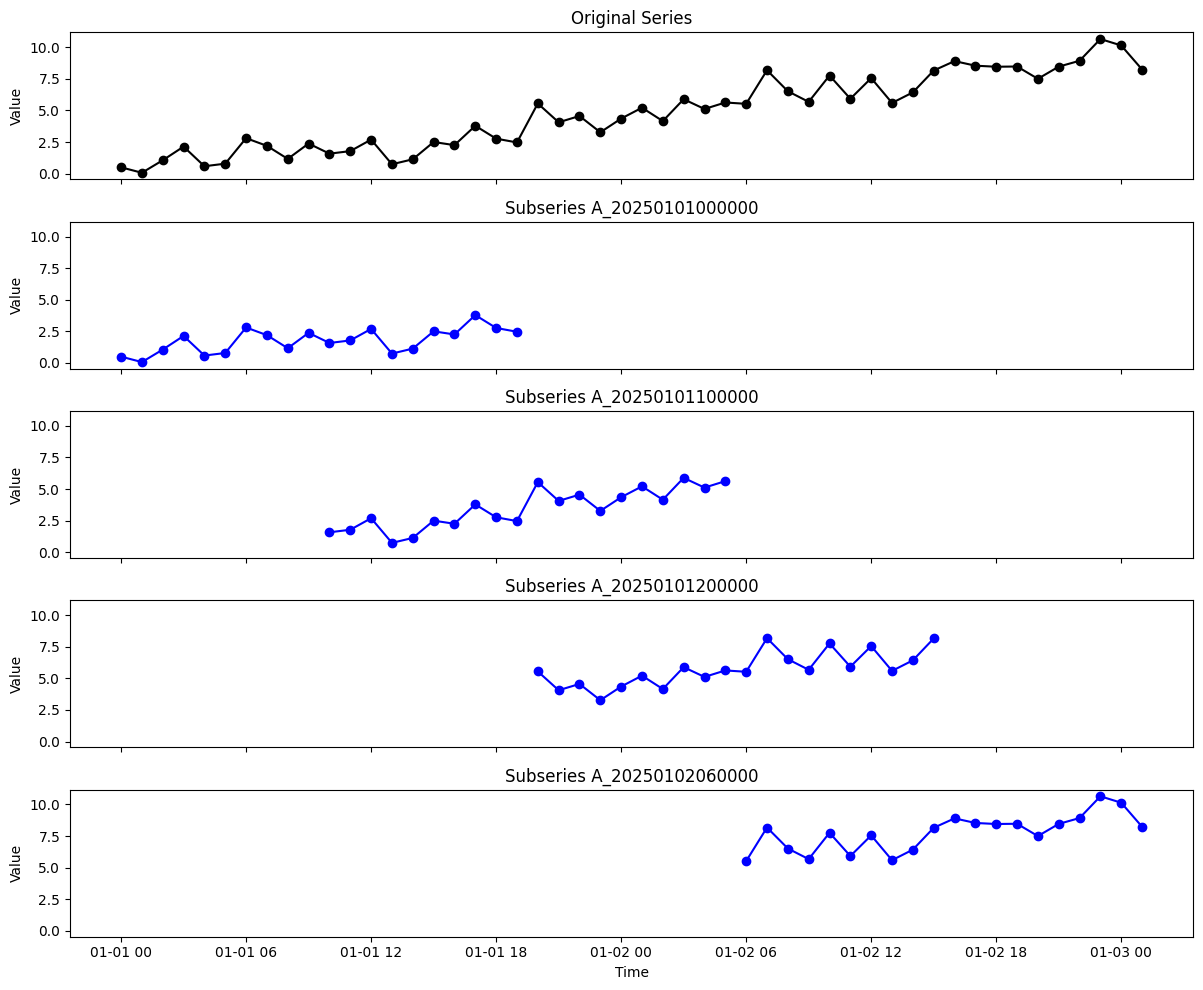

In [7]:

#@title Example: Generate long series and split
# -------------------------
# Generate synthetic long series
np.random.seed(42)
n_points = 50
time = pd.date_range("2025-01-01", periods=n_points, freq="h")
values = np.linspace(0, 10, n_points) + np.random.normal(0, 1, n_points)  # trend + noise

df = pd.DataFrame({"entity": "A", "time": time, "value": values})

# Split into subseries of length 10 with step 5
df_sub = split_time_series(df, window_size=20, step_size=10, id_format="time")

# -------------------------
# Plot original + subseries
# -------------------------
sub_ids = df_sub["subseries_id"].unique()
n_sub = len(sub_ids)

fig, axes = plt.subplots(n_sub + 1, 1, figsize=(12, 2 * (n_sub + 1)), sharex=True, sharey=True)

# Plot original series
axes[0].plot(df["time"], df["value"], marker="o", color="black")
axes[0].set_title("Original Series")
axes[0].set_ylabel("Value")

# Plot each subseries
for i, sub_id in enumerate(sub_ids, start=1):
    sub_df = df_sub[df_sub["subseries_id"] == sub_id]
    axes[i].plot(sub_df["time"], sub_df["value"], marker="o", color="blue")
    axes[i].set_title(f"Subseries {sub_id}")
    axes[i].set_ylabel("Value")

plt.xlabel("Time")
plt.tight_layout()
plt.show()